In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker

from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

In [11]:
# https://medium.com/@jyson88/python3-os-module-%EC%82%AC%EC%9A%A9-%EB%B0%A9%EB%B2%95-3e6d71b1cec8 
# os module usage tip link

In [18]:
os.getcwd()

'C:\\Users\\user\\jeongiitae\\skt_\\SD_'

In [19]:
os.listdir('dataset/')

['bus_bts.csv',
 'jeju_weather_dataset',
 'loc.xlsx',
 'submission_sample.csv',
 'test.csv',
 'train.csv']

In [24]:
def load_dataset(path):
    train = pd.read_csv(path + 'train.csv', parse_dates=['date'])
    test  = pd.read_csv(path + 'test.csv', parse_dates=['date'])
    df_bus = pd.read_csv(path + 'bus_bts.csv', parse_dates = ['geton_date', 'getoff_date'] )
    sample_submission = pd.read_csv(path + 'submission_sample.csv')
    return train, test, df_bus, sample_submission

path = 'dataset/'
%time train, test, df_bus, sample_submission = load_dataset(path)

Wall time: 5 s


In [28]:
# 꿀팁 ! 
display(train.head(1))
display(test.head(1))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## 데이터사이즈는?

In [29]:
print('-- Size --')
print(f'train-size : {train.shape}')
print(f'test-size : {test.shape}')

-- Size --
train-size : (415423, 21)
test-size : (228170, 20)


In [32]:
# train-set 에만 있는 칼럼은?
train.columns.difference(test.columns)

Index(['18~20_ride'], dtype='object')

## Train/Test 는 어떻게 분리되어있는가?

In [33]:
display(train.head(1))
display(test.head(1))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### id에 차이가 있는가?

--> id 에는 Train/Test-set 각각의 key로 사용됨. 특별한 의미를 지니지 않고 테이블의 각 row를 구분짓는데만 사용되기에 모델링 시 제거해줘야하는 column

In [36]:
train['id'].agg(['min', 'max'])

min         0
max    415422
Name: id, dtype: int64

In [37]:
# id 에는 중복되는 경우가 없다.
len(train)

415423

In [39]:
print('Min/Max of id in Test-set')
test['id'].agg(['min','max'])

print( '=' * 40)
print(f'Size : {len(test)}')

Min/Max of id in Test-set
Size : 228170


### date에 차이가 있는가?

; 전체 데이터는 시간을 기준으로 Train/Test-set 으로 나뉘어짐.

- 2019-09-01 ~ 2019-09-30 에 해당하는 데이터는 Train-set
- 2019-10-01 ~ 2019-10-16 에 해당하는 데이터는 Test-set

In [40]:
train.head(1)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# train-set date는?
print('Min/max of date in Train-set')
display(train['date'].agg(['min','max']))

print('=' * 40)
print(f'Size : {len(train)}')

Min/max of date in Train-set


min   2019-09-01
max   2019-09-30
Name: date, dtype: datetime64[ns]

Size : 415423


In [46]:
# test-set date는?
print('Min/max of date in Test-set')
display(test['date'].agg(['min','max']))

print('=' * 40)
print(f'Size : {len(test)}')

Min/max of date in Test-set


min   2019-10-01
max   2019-10-16
Name: date, dtype: datetime64[ns]

Size : 228170


Text(0.5, 1.0, 'Distribution of date in Train/Test-set')

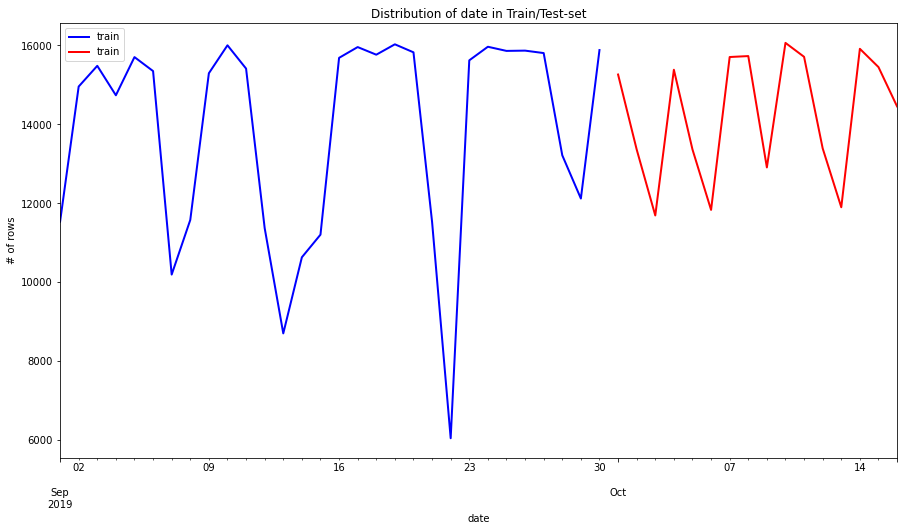

In [47]:
# Train/Test의 date 분포는?

plt.figure(figsize=(15,8))

# Train/Test 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴.
train['date'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test['date'].value_counts().sort_index().plot(color='r', lw=2, label='train')

plt.legend()
plt.xlabel('date')
plt.ylabel('# of rows')
plt.title('Distribution of date in Train/Test-set')

### 정류장에 차이가 있는가?

--> 큰 차이는 없다.

다만,

- Train-set에는 있지만, Test-set에는 없는 bus_route_id가 30개 존재함.
- Test-set에는 있지만, Train-set에는 ㅇ벗는 bus_route_id가 18개 존재함.

Train-set에 등장하지 않으나, Test-set에 등장하는 경우 모델은 학습되지 않은 데이터를 가지고 예측을 해야하는 문제가 있다.

해당 부분들을 어떻게 보완할 지 생각해보는 것도 좋을듯함.

--> 아래에서 확인할 수 있듯이, Test-set에만 등장하는 bus_route_id 는 Train/Test-set에 모두에 등장하는 bus-route-id 보다 평균 탑승승객수가 적은 경향이 있는 듯 보임

--> 해결책 중 하나로, Train-set 기간동안에 해당 bus_route_id의 최근 시간의 탑승 승객수를 '0'으로 레이블링하여 새로운 row를 추가할 수 있을 것이다.

In [48]:
display(train.head(3))
display(test.head(3))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Train/Test 의 고유한 bus_route_id 를 구함.
train_bus_route_id_set = set(train['bus_route_id'])
test_bus_route_id_set = set(test['bus_route_id'])

# Train/test 의 고유한 bus_route의 개수를 구함.
print(f'Train-set의 고유한 bus_route 개수 ; {len(train_bus_route_id_set)}')
print(f'Test-set의 고유한 bus_route 개수 ; {len(test_bus_route_id_set)}')

# Train/Test 에 모두 포함되어있는 bus_route 를 구함.
print('=' * 40)
common_bus_route_id = train_bus_route_id_set.intersection(test_bus_route_id_set)
print(f'Train/Test 에 공통으로 포함되어 있는 bus_route 의 개수 ; {len(common_bus_route_id)}')

# Train 에만 있는 bus_route
print('=' * 40)
only_train_bus_route = train_bus_route_id_set.difference(test_bus_route_id_set)
print(f'Train에만 있는 bus_route의 갯수는 ; {len(only_train_bus_route)}')
print(f'Train에만 있는 bus_route는 ; {sorted(only_train_bus_route)}')

# Test 에만 있는 bus_route
print('=' * 40)
only_test_bus_route = test_bus_route_id_set.difference(train_bus_route_id_set)
print(f'Test에만 있는 bus_route의 갯수는 ; {len(only_test_bus_route)}')
print(f'Test에만 있는 bus_route는 ; {sorted(only_test_bus_route)}')

Train-set의 고유한 bus_route 개수 ; 613
Test-set의 고유한 bus_route 개수 ; 601
Train/Test 에 공통으로 포함되어 있는 bus_route 의 개수 ; 583
Train에만 있는 bus_route의 갯수는 ; 30
Train에만 있는 bus_route는 ; [21160000, 21550000, 21590000, 21860000, 22390000, 23540000, 23630000, 27040000, 27050000, 27140000, 27600000, 28640000, 28780000, 28800000, 28830000, 29170000, 29480000, 29550000, 29570000, 29940000, 30080000, 30210000, 30280000, 30350000, 30360000, 30950000, 31040000, 31220000, 31380000, 32090000]
Test에만 있는 bus_route의 갯수는 ; 18
Test에만 있는 bus_route는 ; [8880000, 20020000, 21510000, 22590000, 23660000, 26260000, 28470000, 28550000, 29180000, 29230000, 29650000, 29850000, 30320000, 30800000, 30990000, 32410000, 32780000, 32790000]


In [57]:
# Test 에만 있는 bus_route_id 와 Train/Test 모두에 등장하는 bus_route_id 의 탑승/하차 칼럼들의 합을 비교해보자.
print('오직 Test에만 존재하는 bus_route_id')
display(test[test['bus_route_id'].isin(only_test_bus_route)].head())

print('=' * 80)

print('오직 Train에만 존재하는 bus_route_id')
display(train[train['bus_route_id'].isin(only_train_bus_route)].head())

오직 Test에만 존재하는 bus_route_id


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
510,415933,2019-10-01,21510000,시내,2746,서귀포등기소,33.25314,126.56015,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
511,415934,2019-10-01,21510000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
11209,426632,2019-10-01,29850000,시내,2,오광로입구,33.49527,126.45618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
11210,426633,2019-10-01,29850000,시내,4,이호2동,33.49488,126.46137,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11211,426634,2019-10-01,29850000,시내,26,하귀초등학교,33.48017,126.40212,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


오직 Train에만 존재하는 bus_route_id


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
474,474,2019-09-01,21550000,시내,1784,중앙로터리(동),33.25297,126.56135,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475,475,2019-09-01,21550000,시내,2972,제주국제공항(종점),33.50571,126.49319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
476,476,2019-09-01,21550000,시내,3271,제주시청(광양방면),33.49892,126.53035,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18221,18221,2019-09-02,27140000,시내,192,함덕환승정류장(함덕해수욕장),33.54101,126.66914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0
18222,18222,2019-09-02,27140000,시내,195,함덕광명샤인빌앞,33.53823,126.67461,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
[col for col in test.columns if '_ride' in col]

['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride']

In [72]:
[col for col in test.columns if '_takeoff' in col]

['6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff']

In [74]:
# 탑승 관련 columns & 하차 관련 columns
ride_columns = [col for col in test.columns if '_ride' in col] + ['bus_route_id', 'date']
take_off_columns = [col for col in test.columns if '_takeoff' in col] + ['bus_route_id', 'date']

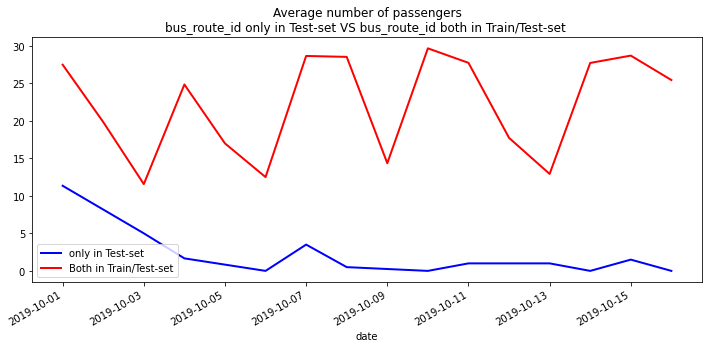

In [82]:
# 두 경우의 탑승 관련 columns 비교
plt.figure(figsize=(12,5))

test[test['bus_route_id'].isin(only_test_bus_route)][ride_columns].groupby(['date','bus_route_id'])['8~9_ride'].sum().groupby('date').mean().plot(color='b', lw=2, label='only in Test-set')
test[test['bus_route_id'].isin(common_bus_route_id)][ride_columns].groupby(['date','bus_route_id'])['8~9_ride'].sum().groupby('date').mean().plot(color='r', lw=2, label='Both in Train/Test-set')
plt.legend()
plt.title("Average number of passengers\nbus_route_id only in Test-set VS bus_route_id both in Train/Test-set ");

### Missing Value 가 존재하는가?

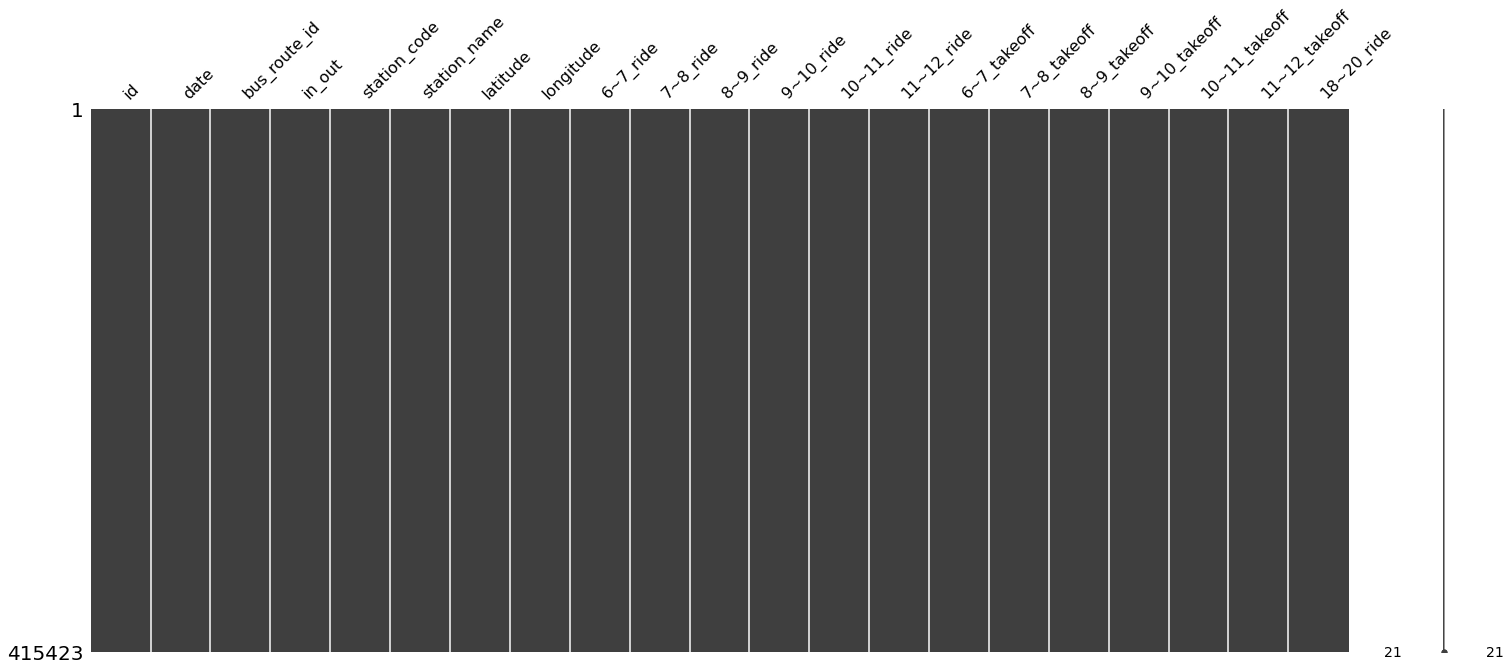

In [92]:
# Missing Values
msno.matrix(train)

In [96]:
# Missing value 확인
print('test')
display(test.isnull().sum())

print('=' * 80)

print('train')
display(train.isnull().sum())

test


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64

train


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

In [99]:
# row 별로
train.isnull().sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
415418    0
415419    0
415420    0
415421    0
415422    0
Length: 415423, dtype: int64

### Target Variable 의 분포는?

In [100]:
target_col = '18~20_ride'

In [107]:
# Target Variable
train[target_col].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
5.0        5911
6.0        4291
7.0        3152
8.0        2288
9.0        1865
10.0       1409
11.0       1183
12.0        996
13.0        807
14.0        660
15.0        597
16.0        508
17.0        450
18.0        408
19.0        394
20.0        331
21.0        261
22.0        234
23.0        218
24.0        198
25.0        168
26.0        194
27.0        150
28.0        144
29.0        132
30.0        113
31.0         94
32.0         80
33.0         79
34.0         77
35.0         78
36.0         58
37.0         61
38.0         64
39.0         53
40.0         37
41.0         51
42.0         43
43.0         41
44.0         52
45.0         37
46.0         32
47.0         35
48.0         21
49.0         28
50.0         26
51.0         24
52.0         21
53.0         24
54.0         22
55.0         22
56.0         20
57.0         17
58.0         21
59.0         13
60.0         16
61.0         20
62.0    

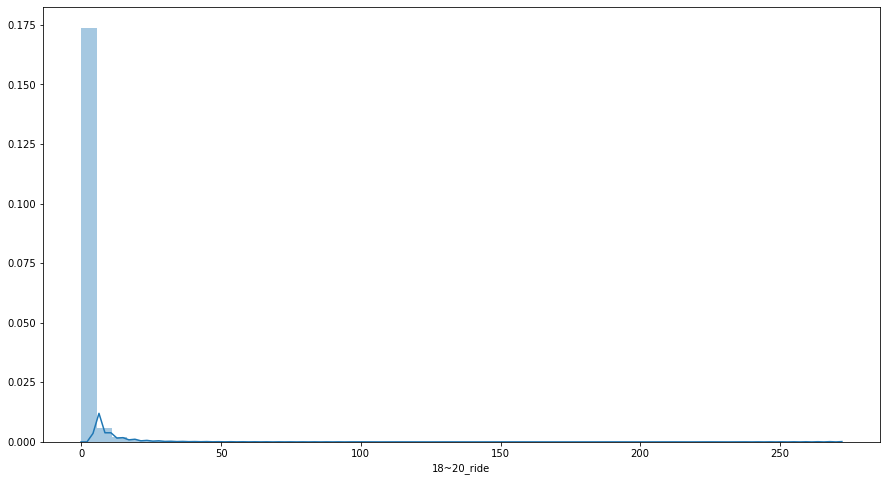

In [111]:
# Dist-plot
# --> (1) 0이 굉장히 많음
# --> (2) right-skewed된 형태이며, 값이 매우 큰 outlier들이 존재함.
plt.figure(figsize=(15,8))
sns.distplot(train[target_col]);

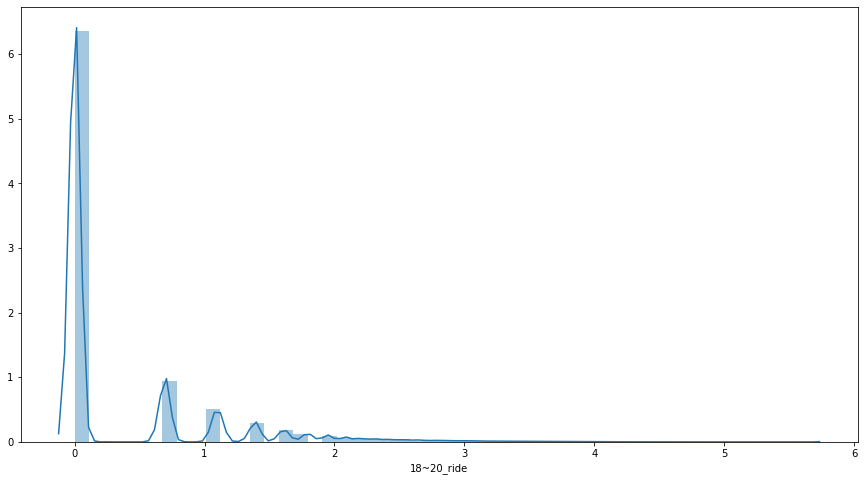

In [114]:
# log1p transformation을 적용해봐도 정규분포에 근사항 모양을 보이지 않음.
plt.figure(figsize=(15,8))
sns.distplot(np.log1p(train[target_col]));

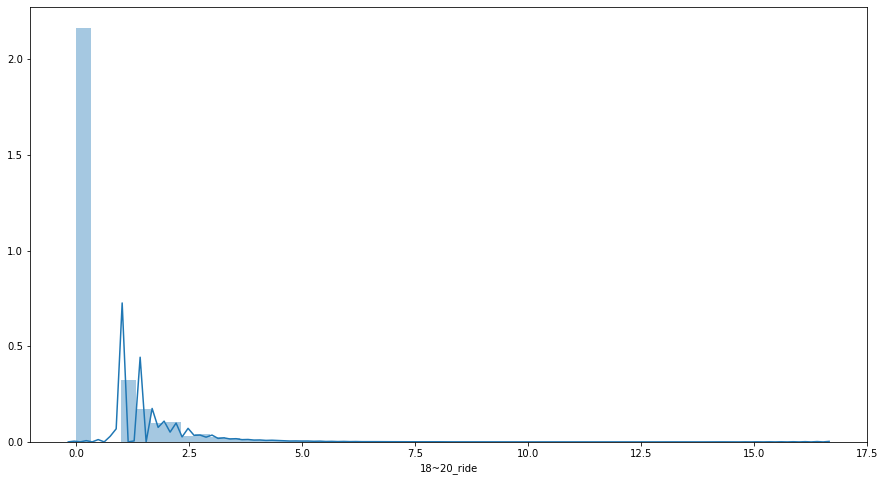

In [115]:
# sqrt transformation , Target 분포를 정규화
plt.figure(figsize=(15,8))
sns.distplot(np.sqrt(train[target_col]));

Target Variable 이 0 인 데이터는 어떤 특징을 가지고 있는가?

In [119]:
train[train['date'] ==datetime(2019,9,1)]
train[ (train['date'] == datetime(2019,9,1)) & (train['bus_route_id'] == 4270000)]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5,2019-09-01,4270000,시내,1648,예래입구,33.25862,126.40442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,6,2019-09-01,4270000,시외,1660,제주국제컨벤션센터중문대포해안주상절리대,33.24309,126.42472,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
7,7,2019-09-01,4270000,시외,1666,창천리,33.26598,126.37082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,8,2019-09-01,4270000,시외,1726,강정농협,33.23603,126.47827,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
9,9,2019-09-01,4270000,시내,2008,서귀포항,33.23977,126.56450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0


In [128]:
# 탑승 관련 columns & 하차 관련 columns
ride_columns = [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col] 

In [130]:
# Train-set의 승차관련 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min','max']) )

# Train-set의 하차관련 칼럼들의 rowsum
display( train[train[target_col]==0][take_off_columns].sum(axis=1).agg(['min','max']) )

# Train-set의 승하차관련 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns + take_off_columns].sum(axis=1).agg(['min','max']) )

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

### 데이터의 특이한 / 주목해야 할 부분>

#### 같은 정류장 이름이 여러 번 나오는 경우?

In [131]:
train.groupby('station_name')['station_code'].nunique()

station_name
(구)구판장        2
(구)중문동주민센터    2
(구)중앙파출소      3
(구)화산초등학교     2
1100고지휴게소     2
             ..
흙통            2
흥국사           2
흥덕사           2
희진주유소         2
히귀반석          1
Name: station_code, Length: 1961, dtype: int64

In [132]:
train.groupby('station_name')['station_code'].agg('nunique')

station_name
(구)구판장        2
(구)중문동주민센터    2
(구)중앙파출소      3
(구)화산초등학교     2
1100고지휴게소     2
             ..
흙통            2
흥국사           2
흥덕사           2
희진주유소         2
히귀반석          1
Name: station_code, Length: 1961, dtype: int64

In [144]:
# (1)의 경우에는 어떤 것들이 있나 예시를 통해 살펴보도록 하자
# 하나의 station_name에 여러 개의 station_code가 기록되어 있는 경우는 어떤 상황인가?
multiple_station_name = train.groupby('station_name')['station_code'].nunique()
multiple_station_name = multiple_station_name[multiple_station_name>=7]
print(multiple_station_name)

df_sample = train[train['station_name'].isin(multiple_station_name.index)][['station_code','station_name','latitude','longitude']]
df_sample = df_sample.drop_duplicates().reset_index(drop=True)
df_sample

station_name
금악리    7
신안동    8
Name: station_code, dtype: int64


,station_code,station_name,latitude,longitude
0,364,신안동,33.51912,126.63493
1,854,신안동,33.51037,126.63498
2,856,신안동,33.51734,126.63563
3,363,신안동,33.51957,126.63523
4,943,금악리,33.36658,126.28713
5,937,금악리,33.35763,126.29492
6,2944,신안동,33.51493,126.63479
7,2945,신안동,33.51500,126.63504
8,702,금악리,33.35743,126.29466
9,853,신안동,33.51007,126.63523


In [145]:
def generateMap(default_location=[33.35098, 126.79807], default_zoom_start=10):
    base_map = folium.Map(location=default_location, 
                          control_scale=True, 
                          zoom_start=default_zoom_start)
    
    # 여러 개의 정거장에 대해서 Icon 생성하기
    for row in df_sample.itertuples():
        station_code, station_name, latitude, longitude = row[1:]
        
        # Create Icon
        if station_name == '금악리':
            icon = Icon(color='red',icon='station')
        else:
            icon = Icon(color='blue',icon='station')
                
        # Add Marker
        Marker(location=[ latitude , longitude], 
               popup=f'station_code : {station_code} station_name : {station_name}',
               icon = icon).add_to(base_map)
        
    
    base_map.save('하나의 station_name에 여러개의 station_code.html')
    return base_map

generateMap()

### 고유한 정거장의 기준은?

3개의 조건을 만족해야 한다.

1. 위경도가 1개이여야함.
2. 시내버스 혹은 시내버스 1개의 노선만 있어야 함.
3. 특정 날짜에 특정 노선에서 특정 정거장의 승객 수를 기록한 row는 1개여야 함.

#### station_name을 기준으로 ?

In [154]:
#train.groupby('station_name')['station_code'].nunique() # station_name 별로 station_code 의 개수
display(train.groupby('station_name')['station_code'].nunique().value_counts()) # train 에서 station_name 별로 station_code 의 개수 

2    1308
1     540
3      60
4      45
5       4
6       2
8       1
7       1
Name: station_code, dtype: int64

In [157]:
display(train.groupby('station_name')['latitude'].nunique().value_counts())
display(train.groupby('station_name')['longitude'].nunique().value_counts())

2    1283
1     566
3      59
4      45
5       4
6       2
8       1
7       1
Name: latitude, dtype: int64

2    1291
1     560
3      58
4      45
5       3
7       2
6       2
Name: longitude, dtype: int64

#### station_code를 기준으로?

In [161]:
display(train.groupby('station_code')['station_name'].nunique().value_counts())

1    3563
Name: station_name, dtype: int64

In [163]:
display(train.groupby('station_code')['latitude'].nunique().value_counts())
display(train.groupby('station_code')['longitude'].nunique().value_counts())

1    3563
Name: latitude, dtype: int64

1    3563
Name: longitude, dtype: int64

OK ~

In [167]:
display(train.groupby('station_code')['in_out'].nunique().value_counts())

1    3563
Name: in_out, dtype: int64

In [169]:
# date / bus_route_id / station_code 이 특정 날짜에 몇 번 등장했는지 재확인 
display( train.groupby(['date', 'bus_route_id', 'station_code']).size().value_counts())
print('=' * 80)
display(f'train size: {len(train)}')

1    415423
dtype: int64

'train size: 415423'

OK ~

## Validation Strategy

아직 발생하지 않은 사건에서 어느 정도의 성능을 보일 지 테스트하기 위하여

_일반데이터_

* KFold / Stratified KFold / Group KFold


_시계열데이터_

* KFold & Stratified KFold / Hold-Out

시간을 기준으로 앞의 3주를 local_train으로, 뒤의 1주를 local_test로 만들어 봄.

1. local_train을 통하여 validation 전략을 실험


2. 해당 모델로 local_test의 값을 예측한 값이 어느정도 차이가 나는지 살펴봄.

In [171]:
# local_train/local_test 
local_train = train[train['date']<='2019-09-24'].reset_index(drop=True)
local_test = train[train['date']>'2019-09-24'].reset_index(drop=True)

In [172]:
display(local_train.head(1))
display(local_test.head(1))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,326655,2019-09-25,4270000,시외,344,제주썬호텔,33.4899,126.49373,5.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


__Categorical Variable __


1. Label-Encoding ; string -> int 맵핑 .


2. One-Hot Encoding ; feature 에 noise 가 많이 껴있을 때 정제작용 됨.


3. Entity Embedding ; 각각의 단어를 벡터로 표현함.


4. Target-Mean Encoding ; 평균적인 추세를 잡을 수 있음.


5. Frequency Encoding ; 빈도수를 통하여 표현.

In [173]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# local_train['bus_route_id'] -> series , lodcal_train[['bus_route_id']] -> dataframe

In [191]:
# local_train과 local_test를 concat하여 temp_df에 저장.
temp_df = pd.concat( [local_train[['bus_route_id']], local_test[['bus_route_id']], ],axis=1)
temp_df_2 = pd.concat( [local_train[['bus_route_id']], local_test[['bus_route_id']], ],axis=0)

display(temp_df.head(1)) # axis 1
display(temp_df_2.head(1)) # axis 0

,bus_route_id,bus_route_id
0,4270000,4270000.0


,bus_route_id
0,4270000


In [ ]:
# lbl.fit
# lbl.classes_
# lbl.inverse_transform

In [192]:
# categorical variable인 'bus_route_id','in_out','station_code','station_name' 에 대해선 label_encoding을 적용해주고,
# numeric variable들에 대해선 있는 그대로 학습을 시켜보도록 한다.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    # local_train과 local_test를 concat하여 temp_df에 저장
    temp_df = pd.concat([ local_train[[col]], local_test[[col]] ] , axis=0)
    
    # Label-Encoding을 fitting함
    lbl.fit( temp_df[col] )
    
    # local_train/local_test에 label_encoding한 값을 대입함
    local_train[col] = lbl.transform(local_train[col])
    local_test[col] = lbl.transform(local_test[col])

## LightGBM을 통하여 모델 평가

In [199]:
n_splits = 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective' : 'rmse',
              'boosting_type' : 'gbdt', 
              'random_state' : 1993,
              'learning_rate' : 0.3,
              'subsample' : 0.7, # 전체 데이터 100개중 70건만 사용한다.
              'tree_learner' : 'serial', 
              'colsample_bytree' : 0.78, # column 중 몇 개를 사용할 것 인가.
              'early_stopping_rounds' : 50,
              'subsample_freq' : 1,
              'reg_lambda' : 7, # 정규화 , 표본의 수에 맞게 설정해주는 것을 추천.
              'reg_alpha' : 5, # 정규화 , 표본의 수에 맞게 설정해주는 것을 추천.
              'num_leaves' : 96,
              'seed' : SEED
            }

# seed  , random_state  -> 매 번 다른식으로 모델링 될 수 있으니 고정된 값 적용토록 유의!

In [201]:
drop_cols = ['id', 'date', target_col]

local_train_label = local_train[target_col]
local_test_label = local_test[target_col]

In [205]:
# local_train/local_test 의 예측값을 저장하기 위한 OOF 만들기 & CV 저장할 list 정의
oof_train = np.zeros((local_train.shape[0], ))
oof_test = np.zeros((local_test.shape[0], ))

cv_list = []

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold 별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook(enumerate( kfolds.split( X = local_train, y = local_train_label ) ) ):
    
    # Train/Valid 정의
    X_train , y_train = local_train.iloc[trn_ind].drop(drop_cols, 1), local_train_label[trn_ind]
    X_valid , y_valid = local_train.iloc[val_ind].drop(drop_cols, 1), local_train_label[val_ind]
    
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의 & 학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND,
                      valid_sets = (dtrain, dvalid),
                      valid_names = ('train', 'valid'),
                      verbose_eval = 100) # epoch 몇 번당 학습의 결과를 내보낼 것인가.
    
    # local_valid / local_test 예측
    valid_pred = model.predict(X_valid)
    test_pred = model.predict( local_test.drop(drop_cols,1) )
    
    # CV를 저장
    cv_list.append( sqrt( mean_squared_error( y_valid, valid_pred ) ) )
    
    # OOF 예측값 저장
    oof_train[val_ind] = valid_pred
    oof_test += test_pred/n_splits
    print('='*80)

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.94824	valid's rmse: 2.91493
Early stopping, best iteration is:
[69]	train's rmse: 2.08891	valid's rmse: 2.89318
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.95413	valid's rmse: 2.81287
[200]	train's rmse: 1.69267	valid's rmse: 2.79212
[300]	train's rmse: 1.53454	valid's rmse: 2.78461
Early stopping, best iteration is:
[262]	train's rmse: 1.58676	valid's rmse: 2.77979
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.93539	valid's rmse: 2.95543
Early stopping, best iteration is:
[51]	train's rmse: 2.20457	valid's rmse: 2.94055
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.97009	valid's rmse: 2.77884
[200]	train's rmse: 1.69023	valid's rmse: 2.77233
Early stopping, best iteration is:
[158]	train's rmse: 1.78114	valid's rmse: 2.76789
Training until validation scores don't improve for 50 rounds
[100]	t

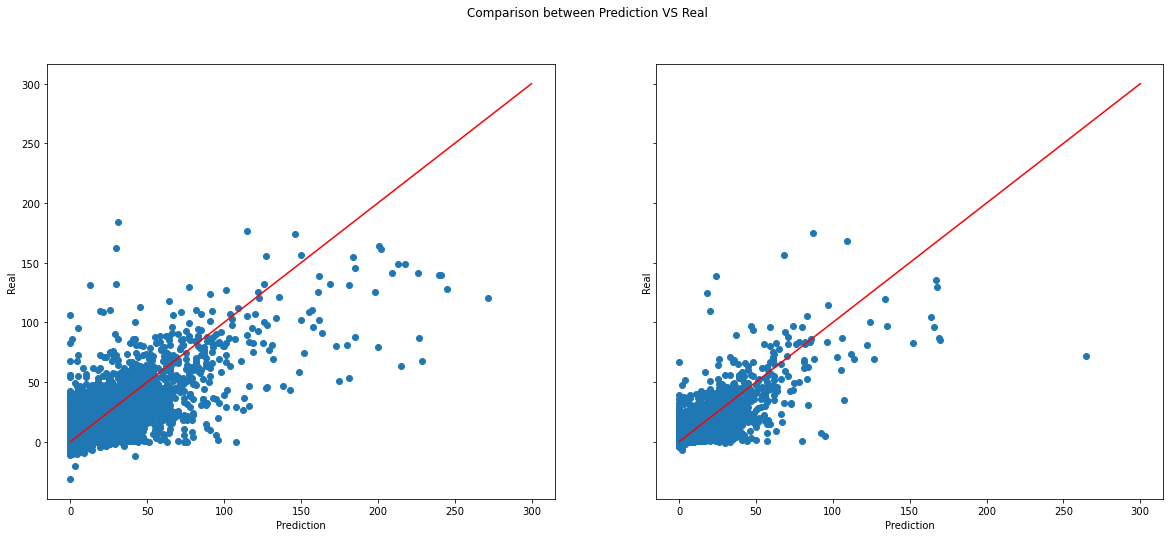

In [206]:
# 실제값과 예측값의 분포 비교
fig, axes = plt.subplots( 1, 2, figsize=(20, 8), sharex=True, sharey=True)

# y=x를 그리기 위하여
x_range = np.linspace(0, 300, 1000)

# <SUBPLOT 1> : local_train에 대한 예측/실제값 비교
axes[0].scatter( local_train_label, oof_train )
axes[0].set_xlabel("Prediction")
axes[0].set_ylabel("Real")

# y=x 그리기
axes[0].plot(x_range, x_range, color='r')

# <SUBPLOT 2> : local_test에 대한 예측/실제값 비교
axes[1].scatter( local_test_label, oof_test )
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Real")

# y=x 그리기
axes[1].plot(x_range, x_range, color='r');

# Super Title 
plt.suptitle('Comparison between Prediction VS Real');

Text(0.5, 1.0, 'Comparing the real vs. prediction in Local-Train')

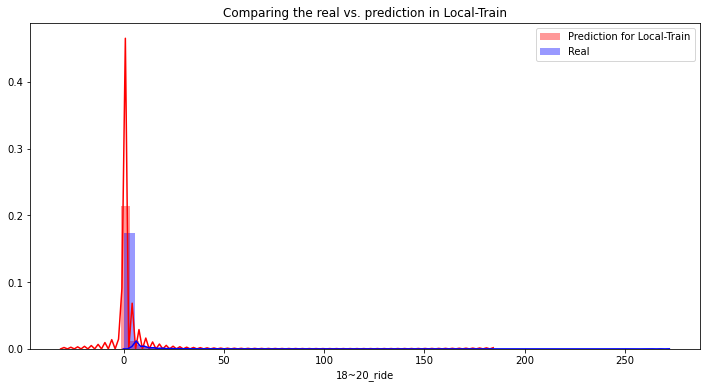

In [207]:
# 실제값 vs. 예측값 비교
plt.figure(figsize=(12,6))

sns.distplot(oof_train, color='r', label='Prediction for Local-Train')
sns.distplot(local_train_label, color='b', label='Real')
plt.legend()
plt.title('Comparing the real vs. prediction in Local-Train')

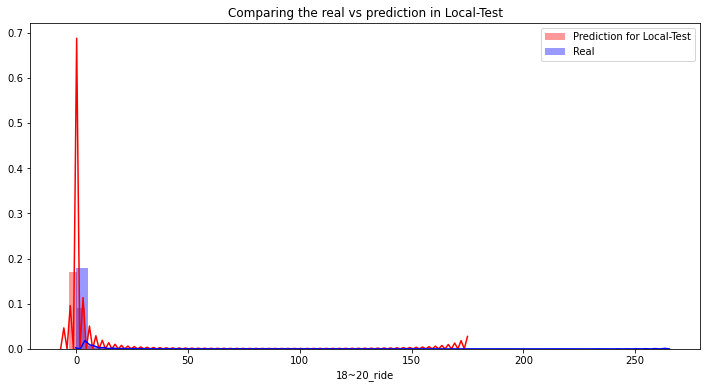

In [208]:
# 실제값 vs 예측값 비교
plt.figure(figsize=(12,6))

sns.distplot( oof_test, color='r' , label='Prediction for Local-Test')
sns.distplot( local_test_label, color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Test");

- LOCAL_TRAIN에 해당하는 부분보다 LOCAL_TEST에 해당하는 부분의 예측력이 떨어지는 모습을 보이긴 함.


- 실제 값보다 예측 값이 지나치게 큰 경우들이 존재하는데, 해당 경우들이 어떤 것들이니 살펴봐야 함.


- 아래와 같은 다른 VALIDATION 기법들도 고려해 볼 것.
    - HOLD OUT
    - GROUP FOLD by weekofmonth
    
- 본 강의에서는 KFOLD를 가지고 baseline model 을 만들어 볼 것임.

In [210]:
# 그래프에서 왜 그런 결과가 나왔는가 traverse
local_test['prediction'] = oof_test
local_test['error'] = local_test[target_col] - local_test['prediction']
local_test.head(1)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,prediction,error
0,326655,2019-09-25,0,1,321,1481,33.4899,126.49373,5.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.72926,-2.72926


Baseline 시 만들어 보면 좋을만한 것들

1. Ridge 2. Lasso 3. Decision Tree 4. Random Forset 5. LightGBM


-> 2개는 선형모델 , 3개는 ML

그러한 이유는 ?

1. cofficient 2. Feature importance


-> 다음과 같은 특성들로부터 좀 더 보완된 모델을 만들어보고자 함.


(PDP Plot)

In [211]:
del local_train, local_test, local_train_label, local_test_label; gc.collect();

In [212]:
# train_label 정의
train_label = train[target_col]

In [213]:
# categorical variable에 대해서는 Label-Encoding을 수행 
# --> One-Hot Encoding가 바람직하다고 생각되나 메모리 문제로 실행할 수 없음.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    
    # Label-Encoding을 fitting함
    lbl.fit( train[col] )
    
    # local_train/local_test에 label_encoding한 값을 대입함
    train[col] = lbl.transform(train[col])

In [214]:
# 각 모델에 대한 oof 정의
ridge_oof_train = np.zeros((train.shape[0]))
lasso_oof_train = np.zeros((train.shape[0]))
dt_oof_train = np.zeros((train.shape[0]))
rf_oof_train = np.zeros((train.shape[0]))
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # (1) Ridge
    print("---TRAINING RIDGE---")
    ridge = Ridge(random_state = 1993)
    
    ridge.fit(X_train, y_train)
    
    ridge_valid_pred = ridge.predict(X_valid)
    ridge_oof_train[val_ind] = ridge_valid_pred
    
    # (2) Lasso
    print("---TRAINING LASSO---")
    lasso = Lasso(random_state = 1993)
    
    lasso.fit(X_train, y_train)
    
    lasso_valid_pred = lasso.predict(X_valid)
    lasso_oof_train[val_ind] = lasso_valid_pred
    
    # (3) Decision Tree
    print("---TRAINING DECISION TREE---")
    dt = DecisionTreeRegressor(random_state=231)
    
    dt.fit(X_train, y_train)
    
    dt_valid_pred = dt.predict(X_valid)
    dt_oof_train[val_ind] = dt_valid_pred
    
    
    # (4) Random Forest
    print("---TRAINING RANDOM FOREST---")
    rf = RandomForestRegressor(random_state=231, n_estimators=20 )
    
    rf.fit(X_train, y_train)
    
    rf_valid_pred = rf.predict(X_valid)
    rf_oof_train[val_ind] = rf_valid_pred
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 0)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Ridge> OVERALL RMSE         : {sqrt( mean_squared_error( train_label, ridge_oof_train ) )}")
print(f"<Lasso> OVERALL RMSE         : {sqrt( mean_squared_error( train_label, lasso_oof_train ) )}")
print(f"<Decision-Tree> OVERALL RMSE : {sqrt( mean_squared_error( train_label, dt_oof_train ) )}")
print(f"<Random-Forest> OVERALL RMSE : {sqrt( mean_squared_error( train_label, rf_oof_train ) )}")
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---

<Ridge> OVERALL RMSE         : 3.5256174413470096
<Lasso> OVERALL RMSE         : 3.6478537865113023
<Decision-Tree> OVERALL RMSE : 4.174571185391608
<Random-Forest> OVERALL RMSE : 2.922049207507851
<Light-GBM> OVERALL RMSE     : 2.7959407111209704


_모델 학습에 있어 중요한 피쳐는 무엇인가?_

__Linear Model__

--> linear model 에서 coef를 통하여 어떤 칼럼의 weight가 높은지 파악할 수 있음.

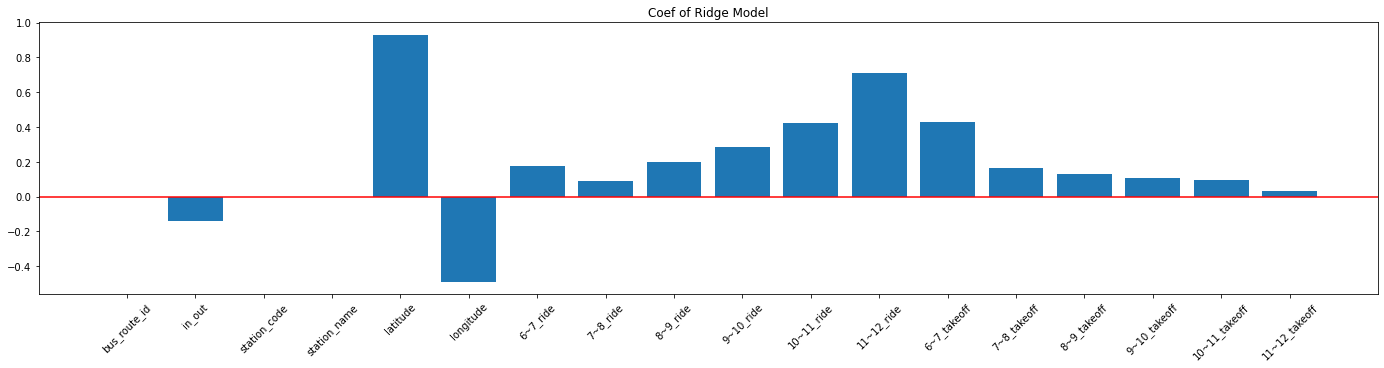

In [215]:
plt.figure(figsize=(24 , 5))

plt.bar(train.drop(drop_cols, 1).columns, ridge.coef_)

plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title('Coef of Ridge Model');

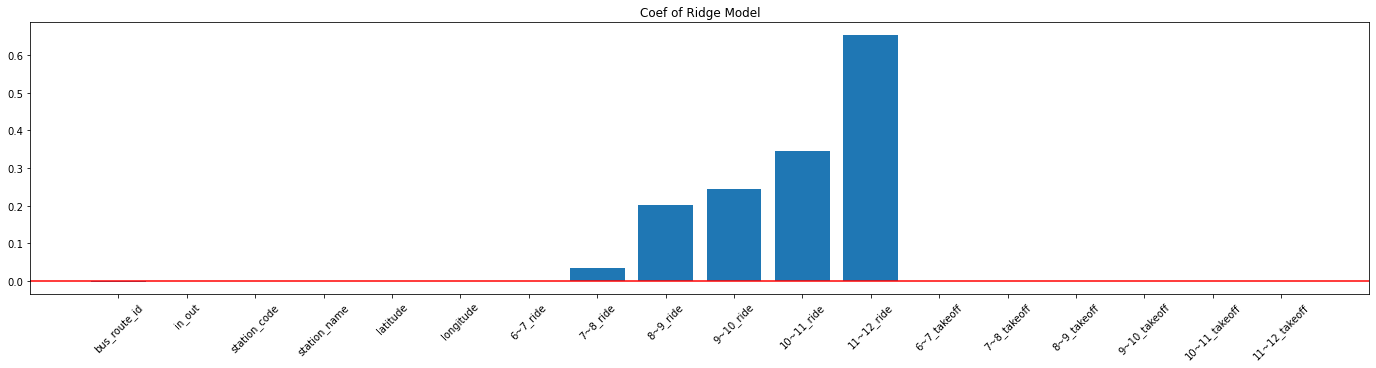

In [216]:
plt.figure(figsize=(24 , 5))

plt.bar(train.drop(drop_cols, 1).columns, lasso.coef_)

plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title('Coef of Ridge Model');

In [217]:
# 상관관계 살펴보기.
train.corr()[target_col].sort_values()

bus_route_id    -0.137364
station_code    -0.034048
longitude       -0.021368
id              -0.000544
in_out           0.022116
station_name     0.054216
latitude         0.079261
6~7_takeoff      0.178353
7~8_takeoff      0.219430
6~7_ride         0.262173
8~9_takeoff      0.274360
10~11_takeoff    0.290691
9~10_takeoff     0.295875
11~12_takeoff    0.313540
7~8_ride         0.371751
8~9_ride         0.445316
9~10_ride        0.494085
10~11_ride       0.512666
11~12_ride       0.569747
18~20_ride       1.000000
Name: 18~20_ride, dtype: float64

__Tree-based Model__

- random forest
    
- light gbm

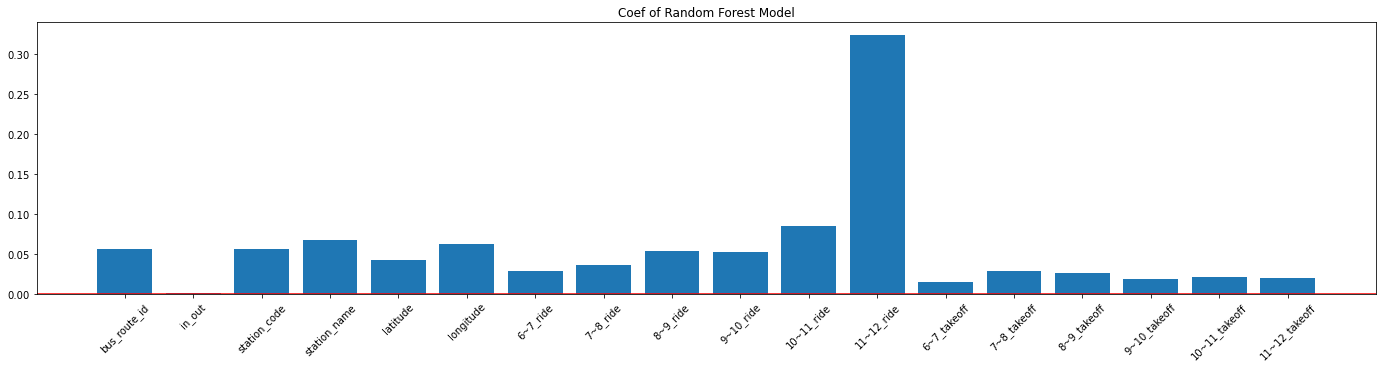

In [218]:
plt.figure(figsize=(24 , 5))

plt.bar(train.drop(drop_cols, 1).columns, rf.feature_importances_)

plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title('Coef of Random Forest Model');

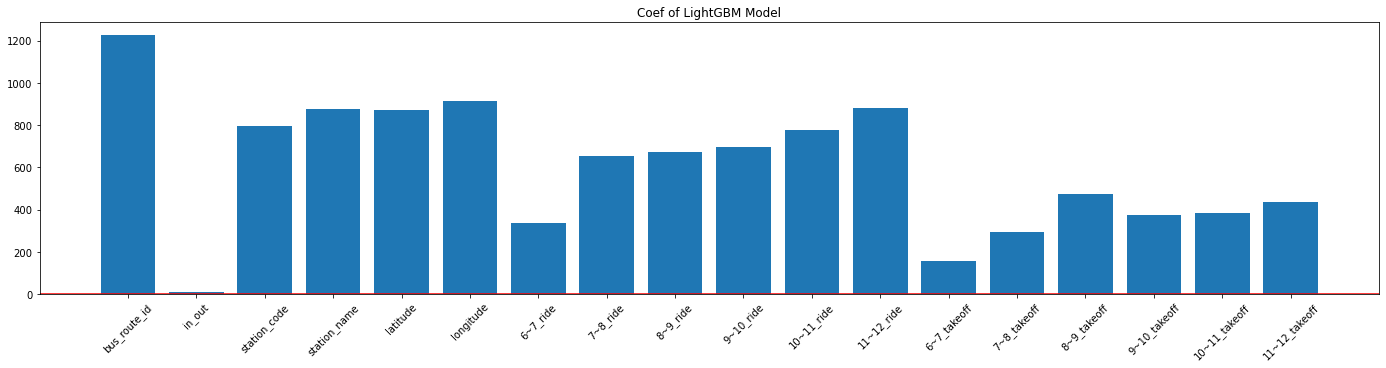

In [223]:
plt.figure(figsize=(24 , 5))

plt.bar(train.drop(drop_cols, 1).columns, model.feature_importance())

plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title('Coef of LightGBM Model');

_PDP PLOT_

__Partial Dependency Plot 을 통하여 특정 칼럼의 값이 변할 때 Target Variable 이 어떤 식으로 영향을 받는지 살펴보도록 하자.__

In [224]:
# 전체 확인시 시간소요가 상당하므로 샘플링하여 일부만 살펴보도록함.
sample = train.drop(drop_cols,1).sample(1000)

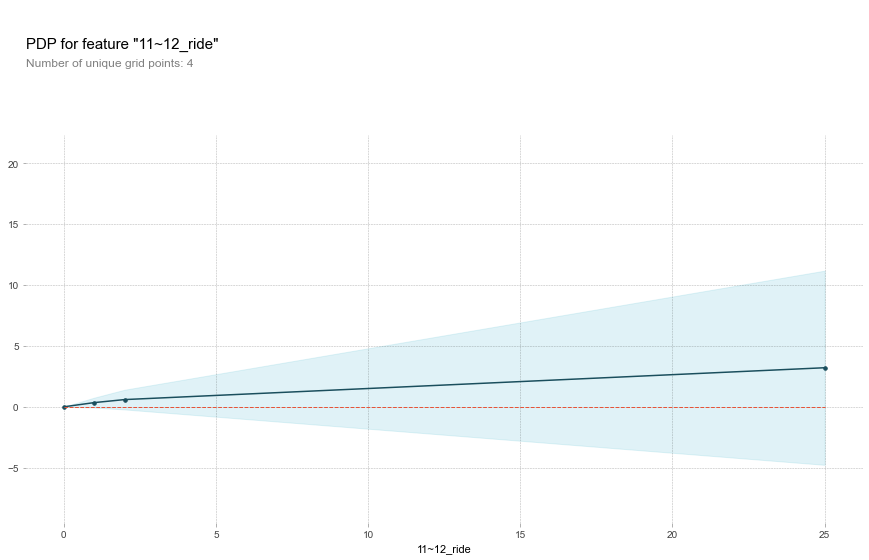

In [225]:
# PDP Plot For 11~12_ride
pdp_ = pdp.pdp_isolate(
    model = model, dataset=sample, model_features=list(sample), feature='11~12_ride'
)
fig, axes = pdp.pdp_plot(pdp_, '11~12_ride')

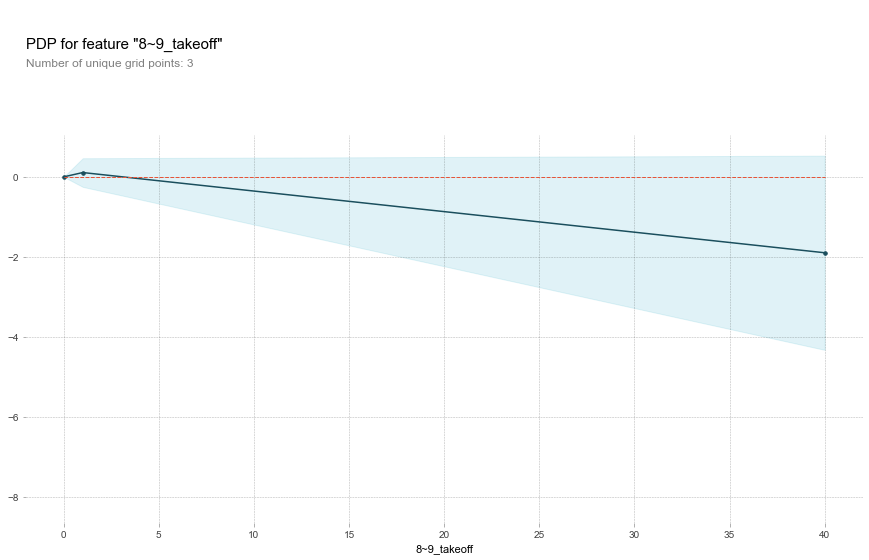

In [226]:
# PDP Plot For 8~9_takeoff
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='8~9_takeoff'
)
fig, axes = pdp.pdp_plot(pdp_, '8~9_takeoff')

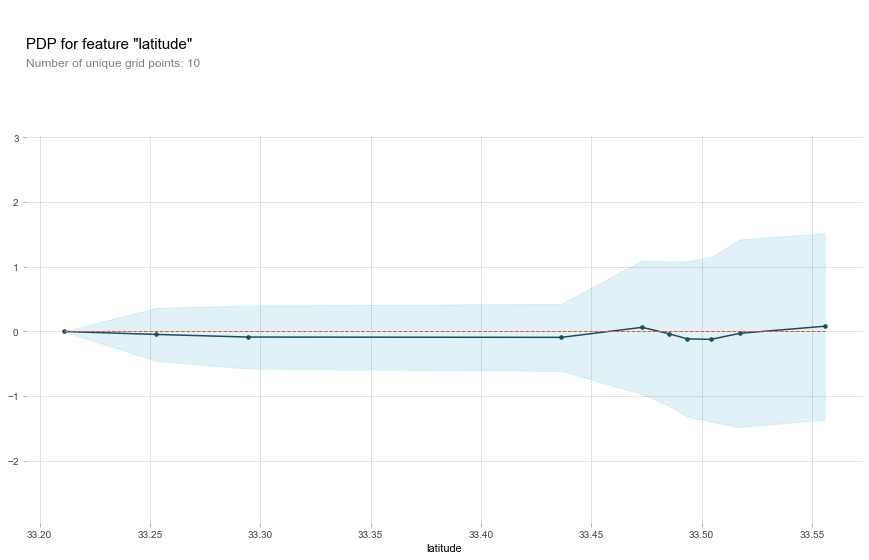

In [227]:
# PDP Plot For latitude
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='latitude'
)
fig, axes = pdp.pdp_plot(pdp_, 'latitude')

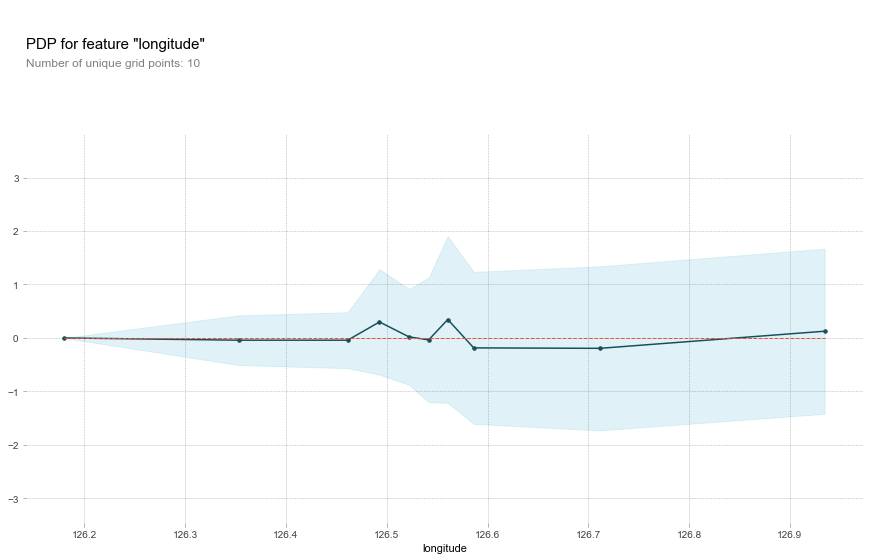

In [228]:
# PDP Plot For longitude
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='longitude'
)
fig, axes = pdp.pdp_plot(pdp_, 'longitude')


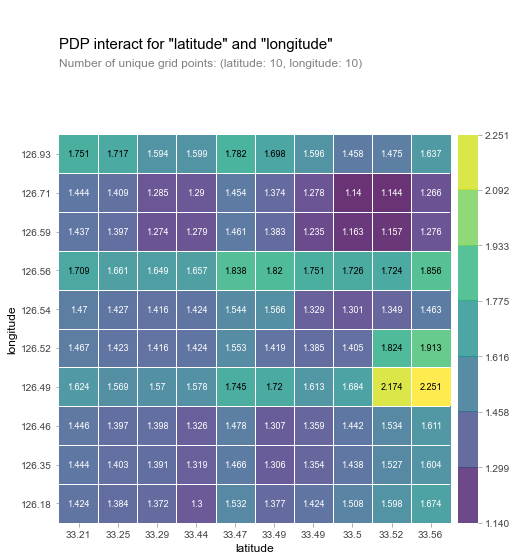

In [229]:
# Interactive PDP Plot For latitude,longitude
pdp_ = pdp.pdp_interact(
    model= model, dataset=sample, model_features=list(sample), features=['latitude','longitude']
)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_,
                                  feature_names=['latitude','longitude'],
                                  plot_type='grid',
                                  x_quantile=True,
                                  plot_pdp=False)

## 엔티티를 활용하여 피쳐 만들기

### ideation

- 버스 노선
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Target Mean Encoding)
    - 날짜별로 오전 시간 승객들이 얼마나 버스를 이용하였는가?
- 버스 
    - 배차시간
- 승객
    - 승하차를 1시간 단위로 해야하는가?
- 정류장
    - 정류장의 순서 
    - 특정 정류장이 데이터에 얼마나 자주 등장하였는가?(고정적으로 타는 승객이 있는가 - Frequency Encoding)
    - 지역적 특성(상업 지구, 주거 지구, 학원가)등의 특징을 파악할 수 있는가?
        - 출근 시간에 승차가 많고 퇴근 시간에 하차가 많다면? -> 주거지구
        - 출근 시간엔 하차 내역이 많고 퇴근 시간에 승차가 많다면? -> 학교, 직장 근처 사무 지구
- 특정 날짜
    - 요일 정보
        - 평일과 주말의 승하차 패턴이 다르지 않을까?
            - 초중고 근처 정류장은 주말의 하차 승객 수가 급격히 줄어들 것
            - 같은 주중이라고 할지라도 금요일 밤의 패턴은 다르지 않을까?
    - 공휴일 정보
        - 추석의 영향은?
        - 10월에는 2개의 공휴일이 존재함(개천절, 한글날)
            - 같은 정도의 휴일이라고 할 수 있을까?
    - 날씨 정보
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Mean Encoding / 퇴근 시간의 하차 패턴 - Target Mean Encoding)
- 제주도   

In [230]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

In [232]:
# 데이터를 load합니다.
# train/test --> string형식으로 저장되어 있는 `date` column은 datetime형식으로 수집합니다.
# bus_bts    --> string형식으로 저장되어 있는 `geton_date`, `getoff_date` columns은 datetime형식으로 수집합니다.
def load_dataset(path):
    train = pd.read_csv(path + 'train.csv', parse_dates=['date'])
    test  = pd.read_csv(path + 'test.csv', parse_dates=['date'])
    df_bus = pd.read_csv(path + 'bus_bts.csv', parse_dates = ['geton_date', 'getoff_date'] )
    sample_submission = pd.read_csv(path + 'submission_sample.csv')
    return train, test, df_bus, sample_submission

path = 'dataset/'
%time train, test, df_bus, sample_submission = load_dataset(path)

Wall time: 4.8 s


In [233]:
# categorical variable에 대해서는 Label-Encoding을 수행 
# --> One-Hot Encoding가 바람직하다고 생각되나 메모리 문제로 실행할 수 없음.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    
    # Label-Encoding을 fitting함
    lbl.fit( train[[col]].append(test[[col]]) )
    
    # train/test label_encoding한 값을 대입함
    train[col] = lbl.transform(train[col])
    test[col] = lbl.transform(test[col])

In [234]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.30522	valid's rmse: 2.78012
[200]	train's rmse: 2.05878	valid's rmse: 2.7215
[300]	train's rmse: 1.91286	valid's rmse: 2.69211
[400]	train's rmse: 1.80712	valid's rmse: 2.67326
[500]	train's rmse: 1.72668	valid's rmse: 2.6631
[600]	train's rmse: 1.66122	valid's rmse: 2.65129
Early stopping, best iteration is:
[594]	train's rmse: 1.66467	valid's rmse: 2.65075
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.33279	valid's rmse: 2.63949
[200]	train's rmse: 2.07475	valid's rmse: 2.60696
[300]	train's rmse: 1.93039	valid's rmse: 2.58604
[400]	train's rmse: 1.82639	valid's rmse: 2.57759
[500]	train's rmse: 1.74208	valid's rmse: 2.5679
[600]	train's rmse: 1.67498	valid's rmse: 2.558
[700]	train's rmse: 1.6202	valid's rmse: 2.55267
[800]	train's rmse: 1.56949	valid's rmse: 2.54717
[900]	train's rmse: 1.52713	valid's rmse: 2.54634

In [238]:
# 피처 중요도 확인
df_imp = pd.DataFrame(data = {'col' : model.feature_name(),
                             'imp' : model.feature_importance()})
df_imp = df_imp.sort_values(by='imp', ascending=False).reset_index(drop=True)
df_imp

,col,imp
0,bus_route_id,4611
1,latitude,3435
2,station_code,3315
3,longitude,3213
4,station_name,3209
5,11~12_ride,3203
6,10~11_ride,2872
7,9~10_ride,2770
8,8~9_ride,2520
9,7~8_ride,2456


In [240]:
# 승하차 간격을 2시간 간격으로 설정할 수는 없는가? (3시간으로 설정해도 ok -> 결국 실험의 영역)
dawn_ride_cols, dawn_takoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']

# df 가공
def modify_terms(df):
    # ride columns
    df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1)
    df['morning_ride'] = df[morning_ride_cols].sum(axis=1)
    df['noon_ride'] = df[noon_ride_cols].sum(axis=1)
    
    # takeoff columns
    df['dawn_takeoff'] = df[dawn_takoff_cols].sum(axis=1)
    df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
    df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)
    
    # drop columns
    drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takoff_cols + morning_takeoff_cols + noon_takeoff_cols
    df = df.drop(drop_cols, 1)
    
    return df
    

train = modify_terms(train)
test = modify_terms(test)

In [241]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.32544	valid's rmse: 2.73229
[200]	train's rmse: 2.09951	valid's rmse: 2.71639
Early stopping, best iteration is:
[188]	train's rmse: 2.11874	valid's rmse: 2.71177
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.36828	valid's rmse: 2.62823
[200]	train's rmse: 2.13559	valid's rmse: 2.59735
[300]	train's rmse: 1.99957	valid's rmse: 2.58357
[400]	train's rmse: 1.90164	valid's rmse: 2.57635
[500]	train's rmse: 1.8235	valid's rmse: 2.56787
[600]	train's rmse: 1.76332	valid's rmse: 2.56657
[700]	train's rmse: 1.70926	valid's rmse: 2.56073
Early stopping, best iteration is:
[738]	train's rmse: 1.69059	valid's rmse: 2.55864
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.33564	valid's rmse: 2.77304
[200]	train's rmse: 2.11246	valid's rmse: 2.7373
[300]	train's rmse: 1.97

In [242]:
# 피쳐 중요도 확인
df_imp = pd.DataFrame(data = {'col': model.feature_name(),
                              'imp': model.feature_importance()})
df_imp = df_imp.sort_values(by='imp', ascending=False).reset_index(drop=True)
df_imp 

,col,imp
0,bus_route_id,4339
1,noon_ride,3946
2,morning_ride,3573
3,dawn_ride,3090
4,latitude,3050
5,longitude,3007
6,station_code,2945
7,station_name,2938
8,morning_takeoff,2669
9,noon_takeoff,2381


### 날짜

- 요일 정보
    - 평일과 주말의 승하차 패턴이 다르지 않을까?
        - 초중고 근처 정류장은 주말의 하차 승객 수가 급격히 줄어들 것
        - 같은 주중이라고 할지라도 금요일 밤의 패턴은 다르지 않을까?
    - 공휴일 정보
        - 추석의 영향은?
        - 10월에는 2개의 공휴일이 존재함(개천절, 한글날)
            - 같은 정도의 휴일이라고 할 수 있을까?
    - 날씨 정보
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Mean Encoding / 퇴근 시간의 하차 패턴 - Target Mean Encoding)


In [243]:
# 요일 정보 추가
train['weekday'] = train['date'].dt.weekday
test['weekday']  = test['date'].dt.weekday

# 공휴일 정보 추가
# -> EDA필요
holidays = [datetime(2019, 9 ,12), datetime(2019, 9, 13), datetime(2019, 9 ,14), datetime(2019, 10,3), datetime(2019, 10,9) ]
train['is_holiday'] = train['date'].apply(lambda x: x in holidays).astype(np.int8)
test['is_holiday']  = test['date'].apply(lambda x: x in holidays).astype(np.int8)

In [244]:
# Mean Encoding
# (1) 일자별로 dawn, morning, noon에 각각 몇몇의 승객이 탑승하였는가
# (2) 일자별로 dawn, morning, noon에 각각 몇몇의 승객이 하차하였는가
# - 기준 :
# - (1) bus_route_id
# - (2) bus_route_id , station_code
# - (3) station_code

# (1) bus_route_id 기준

# 탑승
train['avg_dawn_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
train['avg_morning_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
train['avg_noon_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

test['avg_dawn_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
test['avg_morning_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
test['avg_noon_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

# 하차
train['avg_dawn_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
train['avg_morning_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
train['avg_noon_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

test['avg_dawn_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
test['avg_morning_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
test['avg_noon_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

# (2) bus_route_id, station_code 기준
# train['avg_dawn_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
# train['avg_morning_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
# train['avg_noon_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

# test['avg_dawn_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
# test['avg_morning_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
# test['avg_noon_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

# (3) station_code 기준
# train['avg_dawn_ride_station_code'] = train.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
# train['avg_morning_ride_bus_station_code'] = train.groupby(['date','station_code'])['morning_ride'].transform('mean') 
# train['avg_noon_ride_station_code'] = train.groupby(['date','station_code'])['noon_ride'].transform('mean') 

# test['avg_dawn_ride_station_code'] = test.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
# test['avg_morning_ride_bus_station_code'] = test.groupby(['date','station_code'])['morning_ride'].transform('mean') 
# test['avg_noon_ride_station_code'] = test.groupby(['date','station_code'])['noon_ride'].transform('mean') 



In [245]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.00164	valid's rmse: 2.54135
[200]	train's rmse: 1.77081	valid's rmse: 2.50771
[300]	train's rmse: 1.63921	valid's rmse: 2.49754
[400]	train's rmse: 1.53974	valid's rmse: 2.48969
[500]	train's rmse: 1.46097	valid's rmse: 2.48577
[600]	train's rmse: 1.39647	valid's rmse: 2.48086
[700]	train's rmse: 1.33702	valid's rmse: 2.47684
[800]	train's rmse: 1.28547	valid's rmse: 2.4728
[900]	train's rmse: 1.23979	valid's rmse: 2.4722
Early stopping, best iteration is:
[860]	train's rmse: 1.25823	valid's rmse: 2.47175
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.03825	valid's rmse: 2.32639
[200]	train's rmse: 1.8047	valid's rmse: 2.29216
[300]	train's rmse: 1.66483	valid's rmse: 2.27424
[400]	train's rmse: 1.55802	valid's rmse: 2.25959
[500]	train's rmse: 1.47862	valid's rmse: 2.24994
[600]	train's rmse: 1.40462	valid's rmse: 2.23

In [ ]:
# 날씨 정보
df_weather = pd.read_csv('dataset/jeju_weather_dataset', encoding='cp949')
df_weather = df_weather[['일시','강수량(mm)']]
df_weather.columns = ['date','precipitation']

# date의 type을 string에서 datetime으로 변환
df_weather['date'] = pd.to_datetime( df_weather['date'] )

# 대회 기간에 해당하는 데이터만 사용하도록 함
df_weather = df_weather[(df_weather['date']>='2019-08-31 00:00:00')&(df_weather['date']<='2019-10-16 23:00:00')].reset_index(drop=True)

# 대회 규정상 해당 날짜의 15시까지 정보만 사용할 수 있음
df_weather['hour'] = df_weather['date'].dt.hour
df_weather['date'] = df_weather['date'].dt.date

# 전날의 강수량을 정보를 대입할 때 사용
df_prevday_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()
df_prevday_weather.columns = ['prev_date', 'prevday_precipitation']

# 해당 날짜의 강수량을 구함
df_weather = df_weather[df_weather['hour']<=15].reset_index(drop=True)

# 00~15시까지의 강수량을 피쳐로 사용
df_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()

# Train/Test-set과 join하기 위하여 column의 타입을 datetime으로 변환한다.
df_prevday_weather['prev_date'] = pd.to_datetime( df_prevday_weather['prev_date']  )
df_weather['date'] = pd.to_datetime( df_weather['date']  )

In [ ]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

### 버스 노선

- 해당 정거장이 특정 노선 중 몇 번째 정거장인가?
    - 해당 정거장에는 몇 개의 정거장이 있는가?
    - bus_route_id 별 station_code 순으로 버스가 정차하는 것처럼 보임
- 노선을 numeric type으로 학습시키는 것이 적합한가?
    - categorical vairable로 학습시킨다면?

In [ ]:
# 해당 딕셔너리에 bus_route_id 별 정차 순서를 구하도록 함
bus_route_sequence = {}

# 모든 bus_route_id 수집
combined = train.append(test, ignore_index=True)
all_bus_route_ids = set(combined['bus_route_id'])

for bus_route_id in tqdm_notebook( all_bus_route_ids ) :
    # bus_route_id별 station_code를 오름차순으로 순서매김함
    df_bus_route = combined[combined['bus_route_id']==bus_route_id]
    sorted_station_codes = np.unique(df_bus_route['station_code'])
    
    # dictionary에 해당 정류장이 몇번째 정차 정류장인지 기입
    bus_route_sequence[bus_route_id] = {station_code: ind for ind, station_code in enumerate( list(sorted_station_codes) )}

In [ ]:
# 몇 번째 정류장인지를 피쳐로 생성
train['nth_station']= train[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)
test['nth_station'] = test[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)

In [ ]:
# 해당 bus_route_id에는 몇 개의 정류장이 있는지
bus_route_id_total_station_count_dict = combined.groupby('bus_route_id')['station_code'].nunique().to_dict()

train['bus_route_id_total_staion_count'] = train['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )
test['bus_route_id_total_staion_count']  = test['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )

In [ ]:
# 뒤에서부터 몇 번째 정류정인지
train['nth_station_backward']= train['nth_station'] - train['bus_route_id_total_staion_count']
test['nth_station_backward'] = test['nth_station'] - test['bus_route_id_total_staion_count']

In [ ]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

### 정류장

- Kmeans등을 이용하여 정류장을 군집화 시킨다면?
- 위경도 좌표를 통하여 행정동 or 법정동 정보를 수집할 수 있다면?

In [247]:
# 중복되지 않는 위경도 값들을 수집함
combined = train[['latitude','longitude']].append(test[['latitude','longitude']])
combined = combined.drop_duplicates()

# kmeans를 통하여 군집화
kmeans = KMeans(n_clusters= int(sqrt(len(combined)) ), random_state=1993)
kmeans.fit( combined )

train['station_code_kmeans'] = kmeans.predict(train[['latitude','longitude']])
test['station_code_kmeans']  = kmeans.predict(test[['latitude','longitude']])

In [248]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.78819	valid's rmse: 2.36975
[200]	train's rmse: 1.56074	valid's rmse: 2.35015
Early stopping, best iteration is:
[181]	train's rmse: 1.59323	valid's rmse: 2.34803
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.82573	valid's rmse: 2.17452
[200]	train's rmse: 1.58691	valid's rmse: 2.15773
[300]	train's rmse: 1.44676	valid's rmse: 2.15448
Early stopping, best iteration is:
[288]	train's rmse: 1.45983	valid's rmse: 2.15241
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.80628	valid's rmse: 2.35297
[200]	train's rmse: 1.57059	valid's rmse: 2.33596
Early stopping, best iteration is:
[235]	train's rmse: 1.51665	valid's rmse: 2.33359
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.79554	valid's rmse: 2.37597
[

## Target Encoding

__향후 공부 더 필요함. [Data_Leakage]__

## Feature 선택 / 제거

In [249]:
lgbm_param = {'objective': 'rmse',
             'boosting_type': 'gbdt',
             'random_state': 1993,
             'learning_rate': 0.1,
             'subsample': 0.7,
             'tree_learner': 'serial',
             'colsample_bytree': 0.78,
#              'early_stopping_rounds': 50, error 발생할 수 있기에 # 붙여놓음.
             'subsample_freq': 1,
             'reg_lambda': 7,
             'reg_alpha': 5,
             'num_leaves': 96,
             'seed': 1993}

In [250]:
reg_model = lgbm.LGBMRegressor(**lgbm_param)
rfe = RFECV(estimator=reg_model, step=1, cv=KFold(n_splits=5, shuffle=False, random_state=231), scoring='neg_mean_squared_error', verbose=2)
rfe.fit(train.drop(drop_cols,1), train_label)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFECV(cv=KFold(n_splits=5, random_state=231, shuffle=False),
      estimator=LGBMRegressor(colsample_bytree=0.78, num_leaves=96,
                              objective='rmse', random_state=1993, reg_alpha=5,
                              reg_lambda=7, seed=1993, subsample=0.7,
                              subsample_freq=1, tree_learner='serial'),
      scoring='neg_mean_squared_error', verbose=2)

In [251]:
df_rank = pd.DataFrame(data = {'col': list(train.drop(drop_cols,1)) , 'imp': rfe.ranking_})
use_cols = list(df_rank[df_rank['imp']==1]['col'])

In [252]:
lgbm_param = {'objective': 'rmse',
             'boosting_type': 'gbdt',
             'random_state': 1993,
             'learning_rate': 0.1,
             'subsample': 0.7,
             'tree_learner': 'serial',
             'colsample_bytree': 0.78,
             'early_stopping_rounds': 50,
             'subsample_freq': 1,
             'reg_lambda': 7,
             'reg_alpha': 5,
             'num_leaves': 96,
             'seed': 1993}

In [253]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train[use_cols], y_train)
    dvalid = lgbm.Dataset(X_valid[use_cols], y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid[use_cols])
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.79811	valid's rmse: 2.39651
[200]	train's rmse: 1.56716	valid's rmse: 2.38885
[300]	train's rmse: 1.43249	valid's rmse: 2.3901
Early stopping, best iteration is:
[252]	train's rmse: 1.48978	valid's rmse: 2.38427
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.84174	valid's rmse: 2.18034
[200]	train's rmse: 1.59448	valid's rmse: 2.16231
[300]	train's rmse: 1.45322	valid's rmse: 2.15908
Early stopping, best iteration is:
[289]	train's rmse: 1.46621	valid's rmse: 2.15798
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.80997	valid's rmse: 2.35934
[200]	train's rmse: 1.57718	valid's rmse: 2.33963
Early stopping, best iteration is:
[235]	train's rmse: 1.52357	valid's rmse: 2.33479
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[1

## Test 값 예측 [OOF, Ensemble, Stacking]

In [254]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.01,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.68,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

n_rounds = 100000
cat_params = {
        'n_estimators': n_rounds,
        'learning_rate': 0.08,
        'eval_metric': 'RMSE',
        'loss_function': 'RMSE',
        'random_seed': 42,
        'metric_period': 500,
        'od_wait': 500,
        'task_type': 'GPU',
       'l2_leaf_reg' : 3,
        'depth': 8,
    }

In [255]:
target_col = '18~20_ride'
drop_cols = ['date','id',target_col]
train_label = train[target_col]

In [256]:
# 형식을 맞춰주기 위해서 Test-set에 '18~20_ride' columns을 만들어줌
test[target_col] = np.NaN

In [257]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))
lgbm_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test.drop(drop_cols, 1))
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 3.04014	valid's rmse: 3.08708
[200]	train's rmse: 2.46679	valid's rmse: 2.62569
[300]	train's rmse: 2.23173	valid's rmse: 2.4756
[400]	train's rmse: 2.10465	valid's rmse: 2.41355
[500]	train's rmse: 2.01786	valid's rmse: 2.38418
[600]	train's rmse: 1.95439	valid's rmse: 2.36896
[700]	train's rmse: 1.90279	valid's rmse: 2.35854
[800]	train's rmse: 1.85851	valid's rmse: 2.35294
[900]	train's rmse: 1.82025	valid's rmse: 2.34817
[1000]	train's rmse: 1.78606	valid's rmse: 2.34512
[1100]	train's rmse: 1.75392	valid's rmse: 2.34313
[1200]	train's rmse: 1.72501	valid's rmse: 2.3406
[1300]	train's rmse: 1.69836	valid's rmse: 2.33838
[1400]	train's rmse: 1.67297	valid's rmse: 2.33638
[1500]	train's rmse: 1.64961	valid's rmse: 2.33416
[1600]	train's rmse: 1.6279	valid's rmse: 2.33343
[1700]	train's rmse: 1.60771	valid's rmse: 2.33219
Early stopping, best iteration is:
[1725]	train's rmse: 1.6

In [ ]:
# 각 모델에 대한 oof 정의
cat_oof_train = np.zeros((train.shape[0]))
cat_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) CATBOOST
    print("---TRAINING CATBOOST---")
    
    # model 정의&학습
    model = CatBoostRegressor(**cat_params)
    
    model.fit( X_train, y_train, eval_set = (X_valid, y_valid), 
              cat_features  = ['bus_route_id','station_code', 'station_code_kmeans'],
              use_best_model=True,
              verbose=True)
    
    # local_valid/local_test에 대한 예측
    cat_valid_pred = model.predict(X_valid)
    cat_test_pred = model.predict(test.drop(drop_cols, 1))
        
    cat_oof_train[val_ind] = cat_valid_pred
    cat_oof_test += cat_test_pred/ n_splits
    print('='*80)
    
print(f"<CATBOOST> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, cat_oof_train ) )}")

---TRAINING CATBOOST---
0:	learn: 4.5314679	test: 4.4179686	best: 4.4179686 (0)	total: 84.3ms	remaining: 2h 20m 33s
500:	learn: 1.9261673	test: 2.4130993	best: 2.4130993 (500)	total: 34.5s	remaining: 1h 54m 15s
1000:	learn: 1.7352273	test: 2.3777177	best: 2.3777177 (1000)	total: 1m 10s	remaining: 1h 56m 58s
1500:	learn: 1.6160097	test: 2.3637620	best: 2.3635903 (1495)	total: 1m 47s	remaining: 1h 58m 4s
2000:	learn: 1.5294992	test: 2.3569737	best: 2.3569053 (1990)	total: 2m 25s	remaining: 1h 58m 29s
2500:	learn: 1.4555280	test: 2.3520266	best: 2.3515916 (2392)	total: 3m 3s	remaining: 1h 59m
3000:	learn: 1.3928385	test: 2.3491231	best: 2.3489705 (2986)	total: 3m 40s	remaining: 1h 59m
3500:	learn: 1.3386017	test: 2.3471052	best: 2.3468249 (3491)	total: 4m 18s	remaining: 1h 58m 38s
4000:	learn: 1.2898223	test: 2.3462504	best: 2.3459121 (3769)	total: 4m 55s	remaining: 1h 58m 9s
4500:	learn: 1.2443587	test: 2.3456787	best: 2.3452809 (4438)	total: 5m 33s	remaining: 1h 57m 45s
bestTest = 2.345